# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

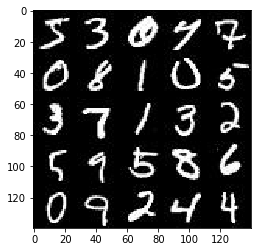

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

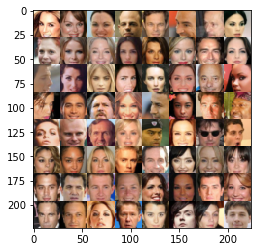

In [4]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # using similar code from DCGAN assignment, added alpha
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        #x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        #bn3 = tf.layers.batch_normalization(x3, training=True)
        #relu3 = tf.maximum(alpha * bn3, bn3)
        # 3.5x3.5x256 ?

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # using similar code from DCGAN assignment, added alpha
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        #x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # using similar code from DCGAN assignment
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # using similar code from DCGAN assignment
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #print(data_shape)
    #tf.reset_default_graph()
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    steps = 0
    print_every = 50
    show_every = 500

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4473... Generator Loss: 3.7172
Epoch 1/2... Discriminator Loss: 0.0007... Generator Loss: 11.4054
Epoch 1/2... Discriminator Loss: 4.8930... Generator Loss: 10.4580
Epoch 1/2... Discriminator Loss: 1.6276... Generator Loss: 0.3294
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 0.8197
Epoch 1/2... Discriminator Loss: 1.1970... Generator Loss: 0.6117
Epoch 1/2... Discriminator Loss: 0.3224... Generator Loss: 2.1755
Epoch 1/2... Discriminator Loss: 0.4904... Generator Loss: 2.1114
Epoch 1/2... Discriminator Loss: 0.5809... Generator Loss: 1.1216
Epoch 1/2... Discriminator Loss: 0.5712... Generator Loss: 1.1308


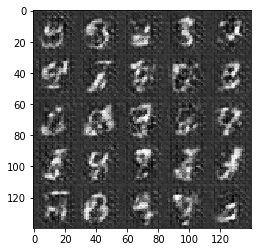

Epoch 1/2... Discriminator Loss: 0.4496... Generator Loss: 1.6239
Epoch 1/2... Discriminator Loss: 0.0723... Generator Loss: 3.3289
Epoch 1/2... Discriminator Loss: 0.9441... Generator Loss: 0.9852
Epoch 1/2... Discriminator Loss: 0.7510... Generator Loss: 3.0411
Epoch 1/2... Discriminator Loss: 0.5749... Generator Loss: 1.6263
Epoch 1/2... Discriminator Loss: 0.6298... Generator Loss: 1.3318
Epoch 1/2... Discriminator Loss: 0.5041... Generator Loss: 1.8344
Epoch 1/2... Discriminator Loss: 1.5058... Generator Loss: 0.4495
Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 0.3735
Epoch 1/2... Discriminator Loss: 1.8016... Generator Loss: 0.2236


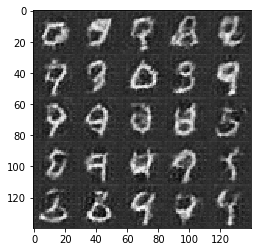

Epoch 1/2... Discriminator Loss: 0.4104... Generator Loss: 1.4621
Epoch 1/2... Discriminator Loss: 0.0227... Generator Loss: 4.7272
Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 2.3365
Epoch 1/2... Discriminator Loss: 0.4338... Generator Loss: 1.4916
Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 1.0002
Epoch 1/2... Discriminator Loss: 0.3669... Generator Loss: 1.6537
Epoch 1/2... Discriminator Loss: 0.0107... Generator Loss: 7.2980
Epoch 1/2... Discriminator Loss: 0.0974... Generator Loss: 3.0417
Epoch 1/2... Discriminator Loss: 0.2479... Generator Loss: 2.1061
Epoch 1/2... Discriminator Loss: 0.0016... Generator Loss: 9.3451


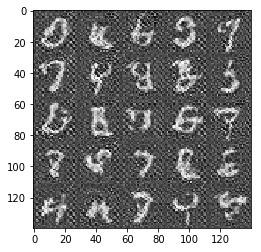

Epoch 1/2... Discriminator Loss: 0.0398... Generator Loss: 4.0687
Epoch 1/2... Discriminator Loss: 0.8715... Generator Loss: 1.2648
Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 2.7105
Epoch 1/2... Discriminator Loss: 1.9501... Generator Loss: 0.2411
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 2.1487
Epoch 1/2... Discriminator Loss: 0.9152... Generator Loss: 0.9342
Epoch 1/2... Discriminator Loss: 0.6308... Generator Loss: 1.2853
Epoch 2/2... Discriminator Loss: 0.6194... Generator Loss: 1.6014
Epoch 2/2... Discriminator Loss: 1.4287... Generator Loss: 3.6207
Epoch 2/2... Discriminator Loss: 1.1526... Generator Loss: 0.5288


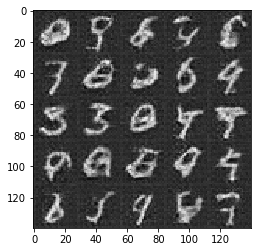

Epoch 2/2... Discriminator Loss: 2.2044... Generator Loss: 0.1602
Epoch 2/2... Discriminator Loss: 0.3211... Generator Loss: 2.1534
Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 1.6770
Epoch 2/2... Discriminator Loss: 0.1275... Generator Loss: 3.0403
Epoch 2/2... Discriminator Loss: 0.0120... Generator Loss: 6.8639
Epoch 2/2... Discriminator Loss: 1.4986... Generator Loss: 0.4679
Epoch 2/2... Discriminator Loss: 0.4706... Generator Loss: 1.6147
Epoch 2/2... Discriminator Loss: 1.8469... Generator Loss: 0.4256
Epoch 2/2... Discriminator Loss: 0.3819... Generator Loss: 2.2405
Epoch 2/2... Discriminator Loss: 0.8159... Generator Loss: 3.1703


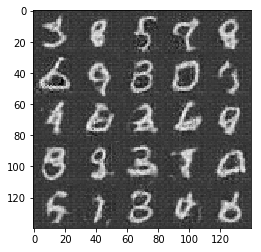

Epoch 2/2... Discriminator Loss: 0.4369... Generator Loss: 3.2739
Epoch 2/2... Discriminator Loss: 0.3283... Generator Loss: 2.9187
Epoch 2/2... Discriminator Loss: 0.0943... Generator Loss: 3.3230
Epoch 2/2... Discriminator Loss: 0.0919... Generator Loss: 3.0629
Epoch 2/2... Discriminator Loss: 0.0344... Generator Loss: 4.2836
Epoch 2/2... Discriminator Loss: 3.7717... Generator Loss: 0.1227
Epoch 2/2... Discriminator Loss: 1.0926... Generator Loss: 3.3372
Epoch 2/2... Discriminator Loss: 0.5116... Generator Loss: 1.2996
Epoch 2/2... Discriminator Loss: 0.5148... Generator Loss: 1.5657
Epoch 2/2... Discriminator Loss: 0.0600... Generator Loss: 3.6885


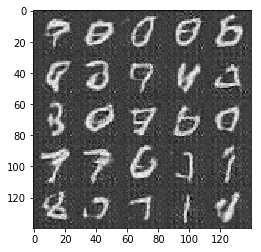

Epoch 2/2... Discriminator Loss: 0.1553... Generator Loss: 2.6609
Epoch 2/2... Discriminator Loss: 0.0263... Generator Loss: 4.8669
Epoch 2/2... Discriminator Loss: 0.7735... Generator Loss: 1.0936
Epoch 2/2... Discriminator Loss: 0.1181... Generator Loss: 3.3236
Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 5.0048
Epoch 2/2... Discriminator Loss: 0.6843... Generator Loss: 0.9587
Epoch 2/2... Discriminator Loss: 0.4969... Generator Loss: 1.6339
Epoch 2/2... Discriminator Loss: 0.0196... Generator Loss: 5.3287
Epoch 2/2... Discriminator Loss: 0.1967... Generator Loss: 2.7685
Epoch 2/2... Discriminator Loss: 0.0010... Generator Loss: 10.6238


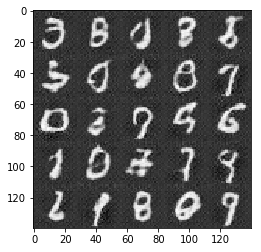

Epoch 2/2... Discriminator Loss: 0.0859... Generator Loss: 3.6877
Epoch 2/2... Discriminator Loss: 0.0099... Generator Loss: 6.1856
Epoch 2/2... Discriminator Loss: 0.7376... Generator Loss: 2.3018
Epoch 2/2... Discriminator Loss: 2.1556... Generator Loss: 2.7530
Epoch 2/2... Discriminator Loss: 0.8836... Generator Loss: 0.9128


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.01
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4742... Generator Loss: 1.6993
Epoch 1/1... Discriminator Loss: 1.8279... Generator Loss: 6.1364
Epoch 1/1... Discriminator Loss: 0.1117... Generator Loss: 4.1590
Epoch 1/1... Discriminator Loss: 0.1622... Generator Loss: 4.1768
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.5080
Epoch 1/1... Discriminator Loss: 0.5011... Generator Loss: 1.8746
Epoch 1/1... Discriminator Loss: 0.3161... Generator Loss: 4.5836
Epoch 1/1... Discriminator Loss: 0.2879... Generator Loss: 3.7687
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 0.2926... Generator Loss: 7.4349


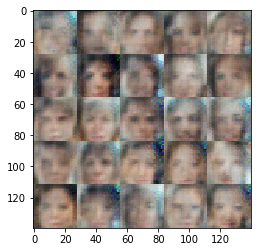

Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 3.3885
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.4080
Epoch 1/1... Discriminator Loss: 0.2952... Generator Loss: 4.9015
Epoch 1/1... Discriminator Loss: 1.7045... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 2.2508... Generator Loss: 0.4564
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 5.8517
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 1.9863
Epoch 1/1... Discriminator Loss: 0.5922... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 2.5688


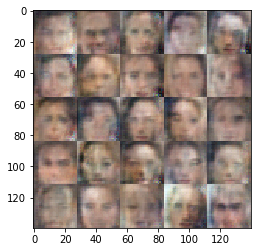

Epoch 1/1... Discriminator Loss: 1.7020... Generator Loss: 2.4963
Epoch 1/1... Discriminator Loss: 0.3198... Generator Loss: 2.7409
Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 4.8102
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 2.2029
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 2.0226
Epoch 1/1... Discriminator Loss: 4.2132... Generator Loss: 0.2354
Epoch 1/1... Discriminator Loss: 0.2498... Generator Loss: 5.7323
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 3.4234
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.1051


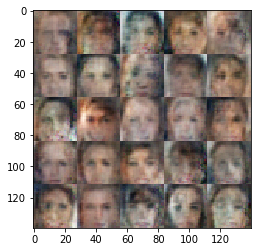

Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 2.5788
Epoch 1/1... Discriminator Loss: 0.2479... Generator Loss: 5.4622
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.2152
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 2.7252
Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 1.5655
Epoch 1/1... Discriminator Loss: 0.3778... Generator Loss: 2.7548
Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 1.8781
Epoch 1/1... Discriminator Loss: 0.3269... Generator Loss: 4.6112
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 5.8366
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 1.3277


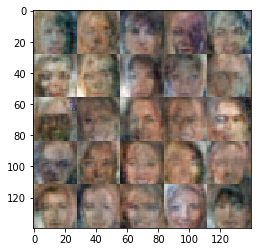

Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 1.6153
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.1082
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 1.9845
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 1.2040
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.6517
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.7723


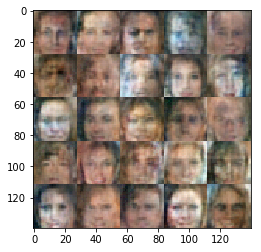

Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 1.1732
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 1.1770
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 1.2060
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 1.1327
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 1.9396
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.5582


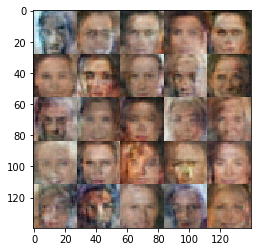

Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 1.2954
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.8189


In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.